In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset,TensorDataset
from autoencoder2 import Autoencoder2, reduce_dimensions2
import torchvision
from model2 import classification_model
import copy
import partition
from pca import PCADigitReducer
from training import train,test, train_fashion,test_fashion
from federated_learning import distribute_global_model, federated_averaging
from model4 import MultilayerPerceptron
import cluster2
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# Preprocessing

In [3]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01 # ev. 0.001
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])


train_dataset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=transform)


kanji_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
kanji_test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
train_loader_pca = copy.copy(kanji_train_loader)
test_loader_pca = copy.copy(kanji_test_loader)

train_loader_auto = copy.copy(kanji_train_loader)
test_loader_auto = copy.copy(kanji_test_loader)

In [6]:
class CustomTensorDataset(TensorDataset):
    def __init__(self, *tensors):
        super().__init__(*tensors)
        self.data = tensors[0]
        self.targets = tensors[1] 

# PCA

# Autoencoder

In [7]:
# Autoencoder
#latent_dim = 100  
autoencoder = Autoencoder2()
auto_criterion = nn.MSELoss()
auto_optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
auto_num_epochs = 5
for epoch in range(auto_num_epochs): 
    for images, _ in train_loader_auto:
        auto_optimizer.zero_grad()
        reconstructed = autoencoder(images)
        loss = auto_criterion(reconstructed, images)  
        loss.backward()
        auto_optimizer.step()
        
    print(f"Epoch [{epoch+1}/5], Loss: {loss.item()}")

Epoch [1/5], Loss: 0.024161722511053085
Epoch [2/5], Loss: 0.018691914156079292
Epoch [3/5], Loss: 0.01589983142912388
Epoch [4/5], Loss: 0.014713124372065067
Epoch [5/5], Loss: 0.011600001715123653


# Experiment

In [8]:
alpha = 0.1
num_clients = 10
num_clusters = [2, 4, 6, 8, 10]
results = {"classic": {}, "pca": {}, "autoencoder": {}}
clusteredResults = {"classic": {}, "pca": {}, "autoencoder": {}}

# Classic

In [9]:
trainingset = kanji_train_loader.dataset
trial_model_strong = MultilayerPerceptron()
global_model_classic_strong = MultilayerPerceptron()
rounds_classic = 8

In [10]:

partitioned_data_classic = partition.balanced_dirichlet_partition(
    trainingset, partitions_number=num_clients, alpha=alpha)

classic_client_loaders = [
    DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_classic.values()
]

local_models_classic_strong = [copy.deepcopy(global_model_classic_strong) for _ in range(num_clients)]


for round_idx in range(rounds_classic):
    print(f"Round {round_idx + 1}/{rounds_classic}")
    t1=time.time()

    local_weights_classic = []
    for client_idx, client_model in enumerate(local_models_classic_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []

        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_classic.append(client_weights)
        

    global_weights_classic = federated_averaging(local_weights_classic)


    distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)

    distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
    test_losses = []
    test_fashion(global_model_classic_strong,kanji_test_loader,test_losses)
    t2= time.time()


    test_accuracies_classic = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in kanji_test_loader:
            data = data.view(data.shape[0], -1)
            output = global_model_classic_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()

    accuracy = 100. * correct / len(kanji_test_loader.dataset)
    test_accuracies_classic.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')


    results["classic"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["classic"]["NoCluster"]["losses"].extend(test_losses)
    results["classic"]["NoCluster"]["accuracy"].extend(test_accuracies_classic)
    results["classic"]["NoCluster"]["precision"].append(precision)
    results["classic"]["NoCluster"]["recall"].append(recall)
    results["classic"]["NoCluster"]["f1"].append(f1)
    results["classic"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_classic.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_classic)
    
    partitioned_data_classic_clustered = clustered_data

    """
    import cluster
    cluster = cluster.Cluster(num_clusters=num_cluster)
    
    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clustered_data = cluster.apply_clustering(partitioned_data_classic, targets, num_classes)
    
    partitioned_data_classic_clustered = clustered_data
    """

    classic_client_loaders_clustered = [
        DataLoader(Subset(trainingset, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_classic_clustered.values()
    ]

    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_classic = []
        for client_idx, client_model in enumerate(local_models_classic_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, classic_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_classic.append(client_weights)
            
    
        global_weights_classic = federated_averaging(local_weights_classic)
    
    
        distribute_global_model(global_weights_classic,local_models_classic_strong,single=False)
    
        distribute_global_model(global_weights_classic,global_model_classic_strong,single=True)
        test_losses = []
        test_fashion(global_model_classic_strong,kanji_test_loader,test_losses)
        t2= time.time()

        test_accuracies_classic = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in kanji_test_loader:
                data = data.view(data.shape[0], -1)
                output = global_model_classic_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()

        accuracy = 100. * correct / len(kanji_test_loader.dataset)
        test_accuracies_classic.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        if num_cluster not in clusteredResults["classic"]:
            clusteredResults["classic"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["classic"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["classic"][num_cluster]["accuracy"].extend(test_accuracies_classic)
        clusteredResults["classic"][num_cluster]["precision"].append(precision)
        clusteredResults["classic"][num_cluster]["recall"].append(recall)
        clusteredResults["classic"][num_cluster]["f1"].append(f1)
        clusteredResults["classic"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.289999
Train Epoch: 1 [640/8317 (8%)]	Loss: 2.168645
Train Epoch: 1 [1280/8317 (15%)]	Loss: 1.817209
Train Epoch: 1 [1920/8317 (23%)]	Loss: 1.485193
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.970229
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.899009
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.713524
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.880856
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.628718
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.615173
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.538655
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.629680
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.617834
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.459909
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.325221
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.416644
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.438056
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.256870
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.469217
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.181410
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.0127, Accuracy: 3253/10000 (33%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.140076
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.917497
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.454006
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.494728
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.555329
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.460052
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.312605
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.391498
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.306170
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.176008
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.318277
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.151000
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.199193
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.151678
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.245129
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.355586
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.241159
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.472013
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.177766
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.150576
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.6120, Accuracy: 4917/10000 (49%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.777769
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.306253
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.410078
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.334877
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.185143
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.170564
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.236240
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.228020
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.228131
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.235627
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.095992
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.281056
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.248526
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.116611
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.137362
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.297133
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.170680
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.211486
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.111554
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.166136
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3687, Accuracy: 5582/10000 (56%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.436610
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.172352
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.241443
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.131666
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.362391
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.132872
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.142629
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.127941
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.275363
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.259521
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.124551
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.188297
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.155198
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.090137
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.107700
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.120557
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.174006
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.265082
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.089005
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.193037
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2311, Accuracy: 5995/10000 (60%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.044801
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.188805
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.146689
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.133230
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.225461
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.147530
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.150469
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.146081
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.119169
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.155177
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.187550
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.213574
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.165143
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.205050
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.105311
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.138364
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.114448
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.084532
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.159698
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1446, Accuracy: 6371/10000 (64%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.981074
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.244157
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.206607
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.170912
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.346553
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.123782
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.078686
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.108806
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.118424
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.150766
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.155638
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.090706
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.140332
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.238225
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.121013
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.055775
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.171788
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.198011
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.177030
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0706, Accuracy: 6623/10000 (66%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.787052
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.131396
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.053942
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.238033
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.124293
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.050024
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.041703
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.108715
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.146337
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.120183
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.163724
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.192749
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.152056
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.073731
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.072101
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.131313
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.059972
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.167084
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.197409
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9926, Accuracy: 6818/10000 (68%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.813277
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.121049
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.143211
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.118118
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.091083
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.143548
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.096280
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.111584
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.106208
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.112329
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.276423
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.064967
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.069449
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.075904
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.086432
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.185360
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.216085
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.052326
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.033556
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9448, Accuracy: 6956/10000 (70%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.701843
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.221930
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.063066
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.313786
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.124483
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.280201
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.092390
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.091378
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.137159
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.090891
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.038263
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.037373
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.028314
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.067299
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.083557
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.061707
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.053994
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.264092
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.170138
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1515, Accuracy: 6492/10000 (65%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.214690
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.030850
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.090593
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.067915
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.051434
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.095883
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.020985
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.022047
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.161102
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.087382
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.052004
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.106382
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.046708
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.122683
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.182966
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.052781
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.103517
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.034130
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.076566
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1860, Accuracy: 6515/10000 (65%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.336534
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.073748
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.080632
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.041193
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.126487
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.077612
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.134488
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.035679
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.054981
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.086832
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.081005
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.053953
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.095051
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.009651
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.041534
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.014010
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.028639
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.165363
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.138098
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2046, Accuracy: 6531/10000 (65%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.216880
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.080435
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.119830
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.040198
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.020879
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.044536
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.091554
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.011282
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.062489
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.059907
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.057569
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.024479
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.030549
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.015412
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.017062
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.025124
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.013832
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.015154
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.070445
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2331, Accuracy: 6557/10000 (66%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.315070
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.023481
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.070355
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.025554
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.031740
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.032522
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.015401
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.025887
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.103038
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.025502
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.051449
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.090994
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.027998
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.017862
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.066299
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.028645
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.161538
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.046201
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.017793
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2455, Accuracy: 6577/10000 (66%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.153736
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.047480
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.073664
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.045792
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.038797
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.033768
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.037704
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.021894
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.016713
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005737
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.083669
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.029470
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.017147
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.009592
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.060063
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.131786
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.039819
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.030412
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.018366
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2538, Accuracy: 6656/10000 (67%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.169275
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.017831
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.052813
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.011259
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.014585
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.075564
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.021539
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.020044
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.039848
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.019111
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.021487
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.037738
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.028965
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.010176
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.019893
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.046733
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.020451
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.017579
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.031466
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2642, Accuracy: 6686/10000 (67%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.125622
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.021946
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.016457
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.013835
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.040555
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.020192
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.041267
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.023664
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.018933
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.020183
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.009098
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.013362
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.014927
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.008467
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.022066
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.015769
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.013555
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.019947
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.028320
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2877, Accuracy: 6685/10000 (67%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.264375
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.075729
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.021707
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.009234
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.016713
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.045150
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.086110
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.013257
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.023691
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.015400
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.013534
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009349
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.021406
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.046690
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.013869
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.020139
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.017366
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.042068
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.028723
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0346, Accuracy: 7077/10000 (71%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.163419
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.024644
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.008611
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.038519
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.018745
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.057030
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.038969
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.017478
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.010429
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.019782
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.014118
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.019362
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.046224
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.043499
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.012707
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.045985
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.009549
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.014725
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.010013
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0134, Accuracy: 7155/10000 (72%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.259811
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.037494
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.035068
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.019741
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.015300
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.016393
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.019024
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.007633
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.016777
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.013169
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.094666
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.035115
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.033289
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.023024
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.021612
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.005350
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.029826
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.022461
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.012595
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0097, Accuracy: 7187/10000 (72%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.275116
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.077529
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.070124
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.013223
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.011171
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.018284
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.005408
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.016131
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.076338
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.024810
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.046794
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.031784
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.028505
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.013536
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011425
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.016068
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.005114
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.030712
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.015515
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0060, Accuracy: 7234/10000 (72%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.161447
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.033848
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.023927
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.050395
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.007214
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.006895
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.013971
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.019866
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.016679
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.010004
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.038418
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.015389
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.051329
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.017171
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.014940
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.013717
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.063408
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.035459
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.018514
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0005, Accuracy: 7244/10000 (72%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.335779
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.033677
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.010131
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.015628
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.013484
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.062637
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.063471
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.020773
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.024343
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.013904
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.020304
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.050380
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.026001
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001631
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.021110
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.027841
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.016633
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.008658
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.014331
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0066, Accuracy: 7279/10000 (73%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.188431
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.031488
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.083347
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.028729
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.043231
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.027311
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.014751
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004252
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.008007
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.018993
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.003196
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.035405
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.016367
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.010487
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.017709
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.025277
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.007630
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003871
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.025655
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9972, Accuracy: 7341/10000 (73%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.349319
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.067968
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.035167
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.047137
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.014761
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.037380
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.051467
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.021575
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004260
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002986
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.036904
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.040291
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.006116
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.006214
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.007559
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.014852
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.009204
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.012592
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.012114
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0094, Accuracy: 7334/10000 (73%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.241917
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.042337
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.025065
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.011361
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.009587
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.026914
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.014205
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.009847
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.003567
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.020632
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.015239
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.005846
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.023351
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.078014
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.008799
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.014400
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.012721
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.024119
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.013329
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9369, Accuracy: 7511/10000 (75%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.311901
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.043553
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.021430
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.002626
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.022827
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.033796
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.006602
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.013897
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.032275
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.028887
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.006516
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.005135
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.007757
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.011362
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.005251
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002036
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004141
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.017317
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.006703
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9218, Accuracy: 7570/10000 (76%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.185841
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.051905
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.034406
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.016977
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.037835
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.007834
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009705
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004318
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.001117
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.006176
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.014671
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.024779
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.003206
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.005353
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.032121
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.011149
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.025703
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.012578
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002296
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9201, Accuracy: 7596/10000 (76%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.225230
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.074824
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.003412
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.014258
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.009310
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.024846
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.023112
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.016169
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.030313
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.054820
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.030555
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009501
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005250
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.024617
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.012822
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006367
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004302
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.014069
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.003009
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9123, Accuracy: 7649/10000 (76%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.266741
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.006573
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.019632
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.014570
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.004291
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.002287
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.003200
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.011162
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.013210
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.013267
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.010794
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.006911
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.009703
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.005786
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.001895
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002248
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.005507
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.005750
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.013884
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9183, Accuracy: 7655/10000 (77%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.259795
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.013761
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.041700
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.010694
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006430
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.004960
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.038908
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004851
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.006873
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.009502
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.015905
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.013939
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.064597
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002280
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.004020
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.018193
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.012219
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.005469
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.029107
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9141, Accuracy: 7687/10000 (77%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.179638
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.069364
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.027988
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.032443
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.035887
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.006023
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.010375
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.017276
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.011384
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.011320
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.018882
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.027876
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.041599
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.009400
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.020620
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002899
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.016520
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.005722
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.010776
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9175, Accuracy: 7702/10000 (77%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.136005
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.003055
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.021286
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.022913
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.009268
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.005930
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.031410
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004904
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.015807
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.012518
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.006969
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.003353
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.013800
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.027305
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003739
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.011013
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003767
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.013224
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.012571
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9145, Accuracy: 7715/10000 (77%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.344918
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.027043
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.004701
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.053730
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.011024
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.015000
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.004577
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.001922
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.051584
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.038208
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.020135
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009544
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.019901
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.008811
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.000746
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.005357
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002086
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001906
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.013780
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7811, Accuracy: 7919/10000 (79%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.539700
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.011416
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.019314
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.008560
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.013923
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.011400
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.003761
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002336
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.028706
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.012521
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.054937
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.004333
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.013240
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.016478
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.028224
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.015956
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.005289
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.007013
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.009332
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7457, Accuracy: 7985/10000 (80%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.271597
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.016075
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.053452
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.006986
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002486
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.052334
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.004932
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.005309
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.027804
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002834
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.010544
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.003785
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.013593
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.028639
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.006903
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.008227
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006450
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003652
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002923
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7354, Accuracy: 8009/10000 (80%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.263854
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.042423
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.026350
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.019391
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.015265
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.010546
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.004696
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.035081
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.013977
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005366
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.030703
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.004600
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.015825
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.009154
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.006701
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.001425
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.007823
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.009929
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.008370
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7285, Accuracy: 8039/10000 (80%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.326053
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.102471
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.008366
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.054844
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.051197
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.013796
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.006698
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002110
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004902
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.015878
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.005653
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.041831
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.013362
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.004082
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.019379
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009930
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.014606
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001049
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.007865
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7200, Accuracy: 8072/10000 (81%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.299642
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.073783
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.056529
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.015566
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.040301
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.007392
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009115
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004114
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.000452
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.017198
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.010107
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.000555
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.003533
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002083
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.002675
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003084
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002524
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003783
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.010248
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7155, Accuracy: 8095/10000 (81%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.229844
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.009001
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.023215
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.015369
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.012146
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.009649
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.005102
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.053419
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.008694
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.008545
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.045116
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.010140
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.016065
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.009641
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011100
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009336
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.007857
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.013329
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.022082
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7159, Accuracy: 8108/10000 (81%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.421875
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.020586
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.053238
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.005355
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.008977
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.016198
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009516
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.005508
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.016378
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.033035
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.012221
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.007362
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.007315
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.007220
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.007381
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.038208
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003016
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.006957
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002591
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7119, Accuracy: 8133/10000 (81%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.361332
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.062843
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.014590
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.009902
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.085527
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.011171
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.006746
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.010030
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.007662
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.032621
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.018294
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.007805
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.041365
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.006443
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.028391
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002609
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001741
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.008935
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.012847
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6984, Accuracy: 8186/10000 (82%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.653406
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.058214
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.052516
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.036375
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.004814
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.016923
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.021094
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.012977
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.014099
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.091412
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.014443
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.007318
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.007190
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001169
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.016841
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.015083
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004946
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001218
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.006107
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6973, Accuracy: 8193/10000 (82%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.450832
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.039901
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.003775
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.029836
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.007427
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.028174
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.017222
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002818
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004463
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.008346
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.029406
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.002389
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005109
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.009545
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.021894
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.005827
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006164
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.007677
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.004772
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6992, Accuracy: 8205/10000 (82%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.318221
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.299105
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.019608
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.012279
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006483
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.005272
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.013725
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.001072
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.003756
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.026834
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.027987
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.005009
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.011236
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.004336
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011062
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.001031
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.007381
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001951
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.004273
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6984, Accuracy: 8218/10000 (82%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.240239
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.166606
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.030318
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.025297
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.030755
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.003101
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.102566
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.032768
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.002631
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.019634
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.003807
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.020255
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.008841
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.005555
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.009504
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.000947
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.005150
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001827
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.003565
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.6983, Accuracy: 8236/10000 (82%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.300406
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.015516
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.001702
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.004017
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006282
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.027922
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.070722
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.013823
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.002173
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002992
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.058384
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.006556
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.003089
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.004116
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.002525
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.004680
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006394
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.007947
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.007957
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7022, Accuracy: 8234/10000 (82%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.177814
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.075617
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.021208
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.007463
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.007182
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.016567
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.007145
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.003834
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.011536
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002471
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.023027
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.022444
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.030664
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002977
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.010327
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006202
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003284
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003367
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.015882
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7013, Accuracy: 8250/10000 (82%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.185224
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.043701
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.020352
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.005802
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002151
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.007114
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.041748
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.014836
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.024339
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.003929
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.022528
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.002721
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.009446
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.017649
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.015811
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.007085
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003480
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.006557
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.012521
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7040, Accuracy: 8252/10000 (83%)



In [11]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.9448033492088318], 'accuracy': [69.56], 'precision': [0.7243828954978028], 'recall': [0.6956], 'f1': [0.6856259722573952], 'trainingTime': [348.79045033454895]}}, 'pca': {}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [1.151488136291504, 1.1860425979614257, 1.2045741121292115, 1.2330753646850585, 1.2455349040985106, 1.2537622356414795, 1.2641637186050414, 1.2876506732940673], 'accuracy': [64.92, 65.15, 65.31, 65.57, 65.77, 66.56, 66.86, 66.85], 'precision': [0.735469664011843, 0.7364732299231797, 0.7348086811671685, 0.736457014483374, 0.73877143507212, 0.7385297042779964, 0.739979897736275, 0.7370748935884743], 'recall': [0.6492000000000001, 0.6515, 0.6530999999999999, 0.6557000000000001, 0.6577, 0.6656, 0.6686, 0.6685], 'f1': [0.6384892909336555, 0.6401706626602183, 0.6414352679498938, 0.643263483152088, 0.6461896768198214, 0.6527010304261657, 0.6568057840842426, 0.6557658025376907], 't

# PCA

In [12]:
trainingset_pca = train_loader_pca.dataset
trial_model_pca_strong = MultilayerPerceptron()
global_model_pca_strong = MultilayerPerceptron()

In [13]:
partitioned_data_pca = partition.balanced_dirichlet_partition(trainingset_pca, partitions_number=num_clients, alpha=alpha)

pca_client_loaders = []
local_models_pca_strong = [copy.deepcopy(global_model_pca_strong) for _ in range(num_clients)]

for client_idx, client_indices in partitioned_data_pca.items():
    client_data = [trainingset_pca[i][0] for i in client_indices]  
    client_labels = [trainingset_pca[i][1] for i in client_indices]  
    
    client_data = torch.stack(client_data, dim=0)
    client_data = client_data.view(client_data.size(0), -1)  
    
    pca = PCADigitReducer(100)
    client_data_reduced = pca.fit_transform(client_data.numpy())  
    
    client_data_reconstructed_np = pca.inverse_transform(client_data_reduced) 
    client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
    
    client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
    client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  
    
    client_dataset_pca = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
    pca_client_loaders.append(DataLoader(client_dataset_pca, batch_size=batch_size_train, shuffle=True))


rounds_pca = 8
for round_idx in range(rounds_pca):
    print(f"Round {round_idx + 1}/{rounds_pca}")
    t1=time.time()

    local_weights_pca = []
    for client_idx, client_model in enumerate(local_models_pca_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                      momentum=momentum)

        train_losses = []
        train_counter = []


        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_pca.append(client_weights)
        

    global_weights_pca = federated_averaging(local_weights_pca)

    distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)

    distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
    test_losses = []
    test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
    t2= time.time()

    test_accuracies_pca = []
    correct = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_pca:
            data = data.view(data.shape[0], -1)
            output = global_model_pca_strong(data)
            pred = output.data.max(1, keepdim=True)[1]
            all_preds.extend(pred.cpu().numpy().flatten())
            all_targets.extend(target.cpu().numpy().flatten())
            correct += pred.eq(target.data.view_as(pred)).sum().item()
    
    accuracy = 100. * correct / len(test_loader_pca.dataset)
    test_accuracies_pca.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    # Save results for non-clustered classic
    results["pca"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

    results["pca"]["NoCluster"]["losses"].extend(test_losses)
    results["pca"]["NoCluster"]["accuracy"].extend(test_accuracies_pca)
    results["pca"]["NoCluster"]["precision"].append(precision)
    results["pca"]["NoCluster"]["recall"].append(recall)
    results["pca"]["NoCluster"]["f1"].append(f1)
    results["pca"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_pca.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_pca)
    
    partitioned_data_pca_clustered = clustered_data

    pca_client_loaders_clustered = []

    # Apply PCA after clustering
    for client_idx, client_indices in partitioned_data_pca_clustered.items():
        client_data = [trainingset_pca[i][0] for i in client_indices]  
        client_labels = [trainingset_pca[i][1] for i in client_indices]  

        client_data = torch.stack(client_data, dim=0)
        client_data = client_data.view(client_data.size(0), -1)  
        
        pca = PCADigitReducer(100)
        client_data_reduced = pca.fit_transform(client_data.numpy())  

        client_data_reconstructed_np = pca.inverse_transform(client_data_reduced)  
        client_data_reconstructed = torch.tensor(client_data_reconstructed_np, dtype=torch.float32)
        
        client_data_reconstructed = client_data_reconstructed.view(-1, 1, 28, 28)
        client_data_reconstructed = (client_data_reconstructed - 0.2860) / 0.3204  

        client_dataset_pca_clustered = CustomTensorDataset(client_data_reconstructed, torch.tensor(client_labels))
        pca_client_loaders_clustered.append(DataLoader(client_dataset_pca_clustered, batch_size=batch_size_train, shuffle=True))


    for round_idx in range(rounds_classic):
        print(f"Round {round_idx + 1}/{rounds_classic}")
        t1=time.time()

        local_weights_pca = []
        for client_idx, client_model in enumerate(local_models_pca_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate,
                          momentum=momentum)
    
            train_losses = []
            train_counter = []
    
    
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, pca_client_loaders[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_pca.append(client_weights)
            
    
        global_weights_pca = federated_averaging(local_weights_pca)
    
        distribute_global_model(global_weights_pca,local_models_pca_strong,single=False)
    
        distribute_global_model(global_weights_pca,global_model_pca_strong,single=True)
        test_losses = []
        test_fashion(global_model_pca_strong,test_loader_pca,test_losses)
        t2= time.time()
    
        test_accuracies_pca = []
        correct = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_pca:
                data = data.view(data.shape[0], -1)
                output = global_model_pca_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
                correct += pred.eq(target.data.view_as(pred)).sum().item()
        
        accuracy = 100. * correct / len(test_loader_pca.dataset)
        test_accuracies_pca.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')

        # Save results for clustered classic
        if num_cluster not in clusteredResults["pca"]:
            clusteredResults["pca"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["pca"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["pca"][num_cluster]["accuracy"].extend(test_accuracies_pca)
        clusteredResults["pca"][num_cluster]["precision"].append(precision)
        clusteredResults["pca"][num_cluster]["recall"].append(recall)
        clusteredResults["pca"][num_cluster]["f1"].append(f1)
        clusteredResults["pca"][num_cluster]["trainingTime"].append(t2-t1)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 2.186069
Train Epoch: 1 [640/8317 (8%)]	Loss: 1.531843
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.785984
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.695843
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.550980
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.339324
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.231871
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.214979
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.321691
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.353225
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.342864
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.153086
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.139484
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.211475
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.296479
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.122325
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.266304
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.283022
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.257497
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.237713
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.1361, Accuracy: 3106/10000 (31%)



c:\Users\nazek\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.855541
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.482922
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.205630
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.254587
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.328562
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.249617
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.177624
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.188696
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.119604
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.188557
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.214910
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.264105
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.180436
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.232849
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.167168
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.059718
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.153723
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.242843
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.152780
Train Epoch: 2 [3840/8317 (46%)]	Loss: 0.051813
Train Epoch: 2 [4480/831

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.9021, Accuracy: 4668/10000 (47%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.326796
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.256125
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.214804
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.174210
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.163020
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.147343
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.266021
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.123151
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.095862
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.086336
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.188831
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.136527
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.126456
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.080191
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.233572
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.110699
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.126672
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.141756
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.107200
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.7200, Accuracy: 5765/10000 (58%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 1.033035
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.320237
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.195919
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.071385
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.098651
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.126321
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.150304
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.095549
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.066826
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.074137
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.140888
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.102464
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.136908
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.177845
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.101946
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.229568
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.238102
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.128029
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.076543
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.5871, Accuracy: 6151/10000 (62%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.668908
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.222272
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.098201
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.030112
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.207243
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.183219
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.110720
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.089474
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.206608
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.100462
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.096948
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.180537
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.189150
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.050967
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.061551
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.043026
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.044583
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.194366
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.160078
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.4816, Accuracy: 6529/10000 (65%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.553261
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.198290
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.265600
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.156900
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.073696
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.087785
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.087635
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.152389
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.048271
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.114522
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.224433
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.024509
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.099438
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.099183
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.041722
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.130650
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.017943
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.068876
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.023958
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.4001, Accuracy: 6803/10000 (68%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.478337
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.214946
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.149540
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.031683
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.073961
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.082284
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.076300
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.045992
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.047006
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.179653
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.032643
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.055610
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.029577
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.031093
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.032451
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.030311
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.046190
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.108504
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.038552
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.3317, Accuracy: 6976/10000 (70%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.446402
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.059855
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.153972
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.119542
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.007911
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.126826
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.017338
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.226539
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.139864
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.156215
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.069510
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.023476
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.114396
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.041288
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.193001
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.060226
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.073577
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.014667
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.103168
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2727, Accuracy: 7128/10000 (71%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.418929
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.098104
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.135509
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.109505
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.176393
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.054834
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.033084
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.059727
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.044345
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.123447
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.120989
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.012503
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.037336
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.042832
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011946
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.101024
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.021688
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.011737
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.067327
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2877, Accuracy: 6724/10000 (67%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.169916
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.045826
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.047243
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.081818
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.016106
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.020575
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.043791
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.011827
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.060370
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.023276
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.008345
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.048645
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.093607
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.031245
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.036749
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.034850
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.054067
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.021972
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.017745
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2586, Accuracy: 6714/10000 (67%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.208563
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.069378
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.006965
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.018018
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.042043
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.037644
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.037292
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.033645
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.019833
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.023873
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.096190
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.011273
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.028268
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.011428
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.041394
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.011491
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.007593
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.009055
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.019865
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2301, Accuracy: 6733/10000 (67%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.108364
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.051065
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.048277
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.013109
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.020795
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.024319
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.022088
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.013768
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.022336
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.009939
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.041670
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.016699
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.015241
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.018159
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.010401
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006167
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.020016
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.044746
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.031735
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.2024, Accuracy: 6763/10000 (68%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.034924
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.029180
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.038522
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.036116
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.004387
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.006293
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.013473
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.025383
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.008247
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.010810
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.037677
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.004723
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.021999
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.020649
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.014969
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006279
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.009304
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003606
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.003190
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1798, Accuracy: 6784/10000 (68%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.217053
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.009064
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.005548
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.019921
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.010307
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.006954
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.002526
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.021999
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.018517
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005357
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.016008
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.011924
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.003116
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.005580
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.004671
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009060
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006817
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.004185
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.014010
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1619, Accuracy: 6811/10000 (68%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.063703
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.008812
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.013387
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.005929
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.008560
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.002968
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.005419
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.003860
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.003784
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.009728
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.005683
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009791
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005844
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.003298
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.009638
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.018103
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.013837
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001360
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.004049
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1455, Accuracy: 6813/10000 (68%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.144282
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.002897
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.006344
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.008293
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006154
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.011840
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.008673
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.010820
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.002566
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.003820
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.001127
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.003134
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.004253
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.003390
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003980
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002540
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.009876
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001707
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.006960
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1347, Accuracy: 6821/10000 (68%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.092414
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.021472
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.018812
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.006344
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.004527
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.001316
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.004454
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.014004
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.006112
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.001645
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.005240
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.012521
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.001567
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002155
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003208
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006601
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001280
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.002985
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.007225
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0776, Accuracy: 7065/10000 (71%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.087160
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.037599
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.004900
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.012364
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.021467
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.009918
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.001135
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.001729
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.003870
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.004007
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.003106
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009329
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.000434
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.005343
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003774
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009443
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002634
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.008538
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001562
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0639, Accuracy: 7094/10000 (71%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.098013
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.042289
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.012420
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.011007
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002390
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.031283
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.011508
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002619
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.008257
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.011061
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.006933
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.003089
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.009907
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.003832
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.001911
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006720
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002523
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.002175
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.008464
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0558, Accuracy: 7107/10000 (71%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.086674
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.011950
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.007882
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.012648
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.010920
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.033117
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.015346
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.012855
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.002700
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.001751
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.001268
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.015786
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.014415
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.016020
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.001647
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002697
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003876
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003689
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.004674
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0464, Accuracy: 7106/10000 (71%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.322107
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.012194
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.002349
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.026345
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.015577
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.000898
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009368
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002723
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.001549
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.018063
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.006554
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009561
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.001165
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001666
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.004107
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002372
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001136
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.012655
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.000641
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0313, Accuracy: 7125/10000 (71%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.115602
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.034267
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.010167
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.003003
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.004711
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.005056
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.002006
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004475
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.006224
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.004342
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.001728
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.022893
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.004423
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002810
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.002030
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009922
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003414
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.000926
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001352
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0203, Accuracy: 7129/10000 (71%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.099766
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.025191
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.002726
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.012226
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.001115
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.000754
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.003539
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.001190
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.019659
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.014517
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.002419
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.002113
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.002702
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.011804
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.009748
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.001518
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004970
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.004121
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002543
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0125, Accuracy: 7137/10000 (71%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.070180
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.023295
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.008557
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.005632
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002616
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.028084
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.007072
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.001254
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.022346
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.006200
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.005211
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.022866
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.006070
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.004020
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.004935
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009537
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004057
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.004769
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.003763
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.0059, Accuracy: 7126/10000 (71%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.201779
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.006205
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.011753
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.005052
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002659
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.022546
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.002800
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.007232
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004621
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.003595
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.002605
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.016567
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.019867
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001231
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.004233
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003571
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002941
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.006325
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.005119
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9751, Accuracy: 7298/10000 (73%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.257448
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.007900
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.013941
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.004465
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002665
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.011584
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009975
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.003692
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.002949
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.004793
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.026934
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.002515
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.009124
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002138
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003328
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.008524
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001157
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003320
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.004021
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9628, Accuracy: 7338/10000 (73%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.114938
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.004489
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.009950
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.001894
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.000999
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.003614
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.001814
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002837
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.006287
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.001288
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.000774
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.015797
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005309
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.000710
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.001959
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002981
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002125
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.004036
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002690
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9517, Accuracy: 7370/10000 (74%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.105126
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.008796
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.017649
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.016330
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006679
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.001696
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.000688
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002078
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.009853
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002623
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.004547
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.012032
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.028998
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.005883
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.008550
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.001895
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.007709
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003034
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001787
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9450, Accuracy: 7364/10000 (74%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.193051
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.016066
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.011047
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.029486
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002013
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.001045
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.002245
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.000196
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.012525
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.001636
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.008020
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.005277
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.015910
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002584
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003899
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002035
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.000900
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.000842
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002314
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9368, Accuracy: 7386/10000 (74%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.135951
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.046084
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.002743
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.027947
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.052757
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.034541
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.009573
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.003394
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.020536
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005320
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.009566
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.008046
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.006783
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001644
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.004347
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.001373
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001417
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.004313
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002129
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9325, Accuracy: 7389/10000 (74%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.033359
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.010125
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.000202
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.002043
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.009741
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.014118
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.000383
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.012913
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.028276
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.003502
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.005654
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.005974
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005893
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.007031
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.001483
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003886
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002846
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.000310
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.000625
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9279, Accuracy: 7392/10000 (74%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.115363
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.007499
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.016556
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.005050
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006733
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.005774
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.003304
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.031440
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.001325
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002436
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.000693
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.002471
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005097
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.000357
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.001104
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.009199
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.000536
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.002631
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001768
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9203, Accuracy: 7407/10000 (74%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.159681
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.002574
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.003257
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.004892
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.003329
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.002427
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.002649
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.012254
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.003731
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002192
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.002887
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.000919
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005008
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002679
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003746
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003084
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006522
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001415
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001965
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8805, Accuracy: 7599/10000 (76%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.355997
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.006878
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.005067
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.003709
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.005649
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.015164
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.010311
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.002126
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.027989
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.000337
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.000674
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.000245
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.006632
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001040
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.007226
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006064
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.005225
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.006190
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.000969
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8667, Accuracy: 7684/10000 (77%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.209532
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.017570
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.006852
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.003650
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.034896
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.019882
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.010481
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.008287
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.002891
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.004386
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.013323
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.009099
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.041660
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.000481
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003774
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.005390
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.000427
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003583
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001196
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8575, Accuracy: 7739/10000 (77%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.337363
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.007770
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.001930
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.038979
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.009133
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.000510
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.002750
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.008396
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.000246
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.000241
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.012380
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.000618
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.051698
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.008661
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.000437
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.001741
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001421
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003267
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001139
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8506, Accuracy: 7761/10000 (78%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.406470
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.194370
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.027182
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.012661
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002688
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.017490
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.003112
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.005114
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.009442
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.011154
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.017579
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.007643
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.012505
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.010309
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.011626
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.002111
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.000682
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.000254
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002865
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8444, Accuracy: 7771/10000 (78%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.307025
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.022877
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.008933
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.009373
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.019841
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.006994
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.014922
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.006241
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004291
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.003859
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.004670
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.008734
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.000950
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001504
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.002641
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003563
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.000615
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001259
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.003846
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8398, Accuracy: 7775/10000 (78%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.388612
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.005659
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.027701
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.010900
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.018093
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.036107
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.017443
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.014833
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.005452
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.000686
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.035759
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.023010
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.006448
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.003285
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003716
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003826
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003375
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001411
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002611
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8331, Accuracy: 7795/10000 (78%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.195293
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.015204
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.012955
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.018318
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.019004
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.000800
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.045713
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.003199
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.004165
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.012357
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.000594
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.008054
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.004723
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.011790
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.007806
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003620
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.009628
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.002319
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002764
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8297, Accuracy: 7794/10000 (78%)

Round 1/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.196685
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.008302
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.005023
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.004389
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.002344
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.000252
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.000608
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.001821
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.006866
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.002361
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.020244
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.002728
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005953
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.003239
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.007051
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.000337
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002491
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001336
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.001350
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8219, Accuracy: 7796/10000 (78%)

Round 2/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.137488
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.005844
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.002731
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.019398
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.006558
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.000337
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.023748
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.044329
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.016898
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.005023
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.002945
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.003559
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.002864
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.002767
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.000124
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.006857
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.006697
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.002422
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002020
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8198, Accuracy: 7784/10000 (78%)

Round 3/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.091552
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.125681
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.002761
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.018793
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.004341
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.001129
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.006232
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.000629
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.035212
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.001457
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.002642
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.002341
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.004249
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001080
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.007217
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.005078
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001755
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001398
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002448
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8131, Accuracy: 7805/10000 (78%)

Round 4/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.229207
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.031356
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.009507
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.036057
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.015222
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.005594
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.001536
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.000814
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.001277
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.003813
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.006848
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.052316
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.013439
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.003689
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.000345
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.005277
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.002607
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.002601
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.000741
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8100, Accuracy: 7806/10000 (78%)

Round 5/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.114726
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.001101
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.030155
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.007168
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.010711
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.022976
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.010738
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.039712
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.001035
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.015615
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.000582
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.006376
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.005716
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.006244
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.002558
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003887
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004562
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001714
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.003287
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8092, Accuracy: 7795/10000 (78%)

Round 6/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.258081
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.041393
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.026178
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.002866
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.027252
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.009172
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.031477
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.003523
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.003886
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.000365
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.001288
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.000739
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.000985
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001111
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.000544
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.001443
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.003309
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.004149
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002689
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.8009, Accuracy: 7823/10000 (78%)

Round 7/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.276579
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.018077
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.005034
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.010633
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.005034
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.001185
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.000698
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.004919
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.010904
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.011415
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.002702
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.003118
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.001949
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.000927
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.003950
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.000579
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.001413
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.003562
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.002280
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7993, Accuracy: 7813/10000 (78%)

Round 8/8
Training client 1
Train Epoch: 1 [0/8317 (0%)]	Loss: 0.116955
Train Epoch: 1 [640/8317 (8%)]	Loss: 0.068811
Train Epoch: 1 [1280/8317 (15%)]	Loss: 0.006975
Train Epoch: 1 [1920/8317 (23%)]	Loss: 0.001939
Train Epoch: 1 [2560/8317 (31%)]	Loss: 0.007380
Train Epoch: 1 [3200/8317 (38%)]	Loss: 0.000458
Train Epoch: 1 [3840/8317 (46%)]	Loss: 0.018937
Train Epoch: 1 [4480/8317 (54%)]	Loss: 0.009811
Train Epoch: 1 [5120/8317 (62%)]	Loss: 0.007678
Train Epoch: 1 [5760/8317 (69%)]	Loss: 0.001382
Train Epoch: 1 [6400/8317 (77%)]	Loss: 0.003332
Train Epoch: 1 [7040/8317 (85%)]	Loss: 0.000825
Train Epoch: 1 [7680/8317 (92%)]	Loss: 0.000756
Train Epoch: 2 [0/8317 (0%)]	Loss: 0.001493
Train Epoch: 2 [640/8317 (8%)]	Loss: 0.002837
Train Epoch: 2 [1280/8317 (15%)]	Loss: 0.003075
Train Epoch: 2 [1920/8317 (23%)]	Loss: 0.004045
Train Epoch: 2 [2560/8317 (31%)]	Loss: 0.001838
Train Epoch: 2 [3200/8317 (38%)]	Loss: 0.003069
Train Epoch: 2

c:\Users\nazek\anaconda3\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.7954, Accuracy: 7818/10000 (78%)



In [14]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.9448033492088318], 'accuracy': [69.56], 'precision': [0.7243828954978028], 'recall': [0.6956], 'f1': [0.6856259722573952], 'trainingTime': [348.79045033454895]}}, 'pca': {'NoCluster': {'losses': [1.2727488094329833], 'accuracy': [71.28], 'precision': [0.7598305544481903], 'recall': [0.7128], 'f1': [0.7178054356454926], 'trainingTime': [50.25224494934082]}}, 'autoencoder': {}}
Final Results (Clustered): {'classic': {2: {'losses': [1.151488136291504, 1.1860425979614257, 1.2045741121292115, 1.2330753646850585, 1.2455349040985106, 1.2537622356414795, 1.2641637186050414, 1.2876506732940673], 'accuracy': [64.92, 65.15, 65.31, 65.57, 65.77, 66.56, 66.86, 66.85], 'precision': [0.735469664011843, 0.7364732299231797, 0.7348086811671685, 0.736457014483374, 0.73877143507212, 0.7385297042779964, 0.739979897736275, 0.7370748935884743], 'recall': [0.6492000000000001, 0.6515, 0.6530999999999999, 0.6557000000000001, 0.6577, 0.6656, 

In [ ]:
results = {'classic': {'NoCluster': {'losses': [0.9448033492088318], 'accuracy': [69.56], 'precision': [0.7243828954978028], 'recall': [0.6956], 'f1': [0.6856259722573952], 'trainingTime': [348.79045033454895]}}, 'pca': {'NoCluster': {'losses': [1.2727488094329833], 'accuracy': [71.28], 'precision': [0.7598305544481903], 'recall': [0.7128], 'f1': [0.7178054356454926], 'trainingTime': [50.25224494934082]}}, 'autoencoder': {}}
clusteredResults=  {'classic': {2: {'losses': [1.151488136291504, 1.1860425979614257, 1.2045741121292115, 1.2330753646850585, 1.2455349040985106, 1.2537622356414795, 1.2641637186050414, 1.2876506732940673], 'accuracy': [64.92, 65.15, 65.31, 65.57, 65.77, 66.56, 66.86, 66.85], 'precision': [0.735469664011843, 0.7364732299231797, 0.7348086811671685, 0.736457014483374, 0.73877143507212, 0.7385297042779964, 0.739979897736275, 0.7370748935884743], 'recall': [0.6492000000000001, 0.6515, 0.6530999999999999, 0.6557000000000001, 0.6577, 0.6656, 0.6686, 0.6685], 'f1': [0.6384892909336555, 0.6401706626602183, 0.6414352679498938, 0.643263483152088, 0.6461896768198214, 0.6527010304261657, 0.6568057840842426, 0.6557658025376907], 'trainingTime': [80.6618709564209, 72.7041449546814, 73.62729215621948, 70.14149880409241, 76.33348107337952, 73.64698147773743, 79.02745270729065, 71.97399258613586]}, 4: {'losses': [1.0346150493621826, 1.0133999475479125, 1.0097384546279908, 1.0059503798484801, 1.0005213829994202, 1.0066171370506287, 0.9972024836540222, 1.00935540599823], 'accuracy': [70.77, 71.55, 71.87, 72.34, 72.44, 72.79, 73.41, 73.34], 'precision': [0.7479598074173109, 0.7559184606743881, 0.7578264447786932, 0.7593132388549869, 0.7606054839087578, 0.7655268247229243, 0.7669371436527052, 0.7678890770111476], 'recall': [0.7077, 0.7155, 0.7187, 0.7234, 0.7244, 0.7279, 0.7341, 0.7334000000000002], 'f1': [0.6985889473882609, 0.706552111270512, 0.7099865683635909, 0.7145393821054948, 0.7161738225093554, 0.7201362728177638, 0.7263272782169934, 0.7263982163649354], 'trainingTime': [138.01317381858826, 164.00534439086914, 136.23469185829163, 142.50256943702698, 146.72991609573364, 139.46569275856018, 147.979412317276, 142.1271777153015]}, 6: {'losses': [0.9369165079116821, 0.921792333316803, 0.9200711048126221, 0.9123439199447632, 0.9182767298698425, 0.914091606426239, 0.9174560983657837, 0.9145348293304444], 'accuracy': [75.11, 75.7, 75.96, 76.49, 76.55, 76.87, 77.02, 77.15], 'precision': [0.7744012655645321, 0.7792139695741485, 0.7820200274718928, 0.7857938959905864, 0.7863759919432763, 0.788961844868403, 0.7905242952963073, 0.7914386705257451], 'recall': [0.7511, 0.757, 0.7596, 0.7649, 0.7655, 0.7687, 0.7702, 0.7715], 'f1': [0.7472880548812368, 0.7533703152534091, 0.7561612730887549, 0.7617052698233859, 0.7622863366987772, 0.7655992575211785, 0.7672364089574906, 0.768692429274766], 'trainingTime': [183.36669969558716, 169.40811705589294, 173.29706621170044, 189.0247187614441, 174.6814525127411, 176.36225056648254, 191.97809743881226, 209.7849953174591]}, 8: {'losses': [0.7811400805473327, 0.7456655225753784, 0.7353852951049805, 0.7284550909042359, 0.7200480266571045, 0.7155297847747802, 0.7158968052864074, 0.7118582632064819], 'accuracy': [79.19, 79.85, 80.09, 80.39, 80.72, 80.95, 81.08, 81.33], 'precision': [0.8021469498060523, 0.8071151690699674, 0.8097018749862581, 0.8120097786026779, 0.8151595919630731, 0.8168588113461333, 0.8180484470249688, 0.820013429942359], 'recall': [0.7918999999999999, 0.7985, 0.8009000000000001, 0.8039, 0.8072000000000001, 0.8094999999999999, 0.8108000000000001, 0.8133000000000001], 'f1': [0.7909366555940684, 0.7977892309853483, 0.8003182452283228, 0.8033016176866941, 0.8067061769755688, 0.8090831055351527, 0.8102971983095646, 0.8129922277009654], 'trainingTime': [340.4486839771271, 322.2264540195465, 311.7634871006012, 319.13514828681946, 313.3373737335205, 322.9774055480957, 312.39003586769104, 310.7370219230652]}, 10: {'losses': [0.6984300430297852, 0.6972847025871277, 0.6992295879364013, 0.698408555316925, 0.6982962671279908, 0.7021556186676026, 0.7013469363212586, 0.7039833473205567], 'accuracy': [81.86, 81.93, 82.05, 82.18, 82.36, 82.34, 82.5, 82.52], 'precision': [0.8241282101449874, 0.8246822302694008, 0.8259210105544497, 0.8268735171790167, 0.8282785220681894, 0.82839375945823, 0.8295686012231218, 0.8296955098199129], 'recall': [0.8186, 0.8192999999999999, 0.8205, 0.8218, 0.8236000000000001, 0.8234, 0.825, 0.8252], 'f1': [0.8183381228244064, 0.8190278636179352, 0.8202472951482708, 0.8215138735657117, 0.8233296676076177, 0.8231933916908742, 0.8247881845771048, 0.8249801955059104], 'trainingTime': [323.65974736213684, 331.24474263191223, 327.16041564941406, 327.15978598594666, 335.35721135139465, 325.71704864501953, 326.19952297210693, 333.566171169281]}}, 'pca': {2: {'losses': [1.2876727376937867, 1.2586405080795289, 1.230071209716797, 1.2024044576644897, 1.17983577709198, 1.1618732490539552, 1.1454826236724853, 1.1346739295959474], 'accuracy': [67.24, 67.14, 67.33, 67.63, 67.84, 68.11, 68.13, 68.21], 'precision': [0.7446787863459947, 0.7467332151481954, 0.747836911877736, 0.7488833043304648, 0.7510794738095288, 0.7530565600452632, 0.7531674579044438, 0.7526082153534499], 'recall': [0.6723999999999999, 0.6714, 0.6733, 0.6763, 0.6783999999999999, 0.6811, 0.6813, 0.6821], 'f1': [0.6685794112361941, 0.6659004218925375, 0.6672814092743755, 0.6690952035783526, 0.6709277285212341, 0.6740666135257762, 0.6744733941866478, 0.6748793035938672], 'trainingTime': [14.399047136306763, 14.598731279373169, 14.994594097137451, 13.373472452163696, 12.933460712432861, 15.763319253921509, 13.739718914031982, 14.03325366973877]}, 4: {'losses': [1.0776018894195556, 1.063929015636444, 1.0557938883781433, 1.0464061840057373, 1.0312867108345032, 1.0203402983665466, 1.0125327576637269, 1.0059297883033753], 'accuracy': [70.65, 70.94, 71.07, 71.06, 71.25, 71.29, 71.37, 71.26], 'precision': [0.765458472519107, 0.7670198948058902, 0.7702113000601349, 0.7714638221429808, 0.7699507415450094, 0.769998911636949, 0.7707143817649832, 0.7702398240049728], 'recall': [0.7065, 0.7094, 0.7106999999999999, 0.7106, 0.7125, 0.7129000000000001, 0.7137, 0.7126], 'f1': [0.7110281148567634, 0.7145285118995328, 0.7163905937176468, 0.7165616887388732, 0.7174442233918855, 0.7176873760644605, 0.7184612515047178, 0.7177134070569564], 'trainingTime': [23.06351113319397, 22.42156958580017, 20.75409436225891, 20.916213750839233, 18.17861270904541, 20.26260781288147, 19.10610270500183, 23.736359357833862]}, 6: {'losses': [0.9751141966819763, 0.9628466076850891, 0.9517242342948914, 0.945020498752594, 0.9367658240318298, 0.9325048445701599, 0.9278653723716735, 0.9202735835075379], 'accuracy': [72.98, 73.38, 73.7, 73.64, 73.86, 73.89, 73.92, 74.07], 'precision': [0.7781822607024458, 0.7813929335594223, 0.783365131326213, 0.7827857409905681, 0.7836408225637074, 0.7837333992570087, 0.784740052417782, 0.7854002604723191], 'recall': [0.7297999999999999, 0.7338, 0.737, 0.7363999999999999, 0.7385999999999999, 0.7389, 0.7392, 0.7407], 'f1': [0.7359823750202381, 0.7400639087490769, 0.7431579216505668, 0.7426464147793891, 0.7447091355678995, 0.7450123633810323, 0.7455641937717526, 0.7470542900820365], 'trainingTime': [31.177963733673096, 31.741435050964355, 26.325741052627563, 30.79230785369873, 31.052046537399292, 30.926270484924316, 31.883058786392212, 30.322736024856567]}, 8: {'losses': [0.8804715434074402, 0.8667248972892762, 0.8574942947387695, 0.8505845903396606, 0.8444496878623963, 0.8397989877700806, 0.8331117540359497, 0.8296692518234253], 'accuracy': [75.99, 76.84, 77.39, 77.61, 77.71, 77.75, 77.95, 77.94], 'precision': [0.7890356807206012, 0.7920649579381245, 0.7970397522930694, 0.7983289254005139, 0.798885462454135, 0.799387284701554, 0.8002763743128529, 0.8000647684838584], 'recall': [0.7598999999999999, 0.7684000000000001, 0.7739, 0.7761, 0.7771, 0.7775, 0.7795, 0.7794], 'f1': [0.764036128826737, 0.7715899260187988, 0.7770300129601897, 0.7790195825339207, 0.7799610611863326, 0.7804149015690373, 0.7821255921229016, 0.7819866133056441], 'trainingTime': [55.10478448867798, 48.45654058456421, 53.333162784576416, 53.85585594177246, 52.58190965652466, 43.189226150512695, 52.051578998565674, 53.39318776130676]}, 10: {'losses': [0.821871702003479, 0.8198117733001709, 0.8131484815597534, 0.8100267498970032, 0.8091845929145813, 0.8008760778427124, 0.7993201760292054, 0.7954321267127991], 'accuracy': [77.96, 77.84, 78.05, 78.06, 77.95, 78.23, 78.13, 78.18], 'precision': [0.798589740706159, 0.7979628050239371, 0.7983513504569949, 0.7983618809328037, 0.7980744051729138, 0.7994740107972167, 0.7988516541114465, 0.7993865221823565], 'recall': [0.7796, 0.7784, 0.7805000000000001, 0.7806, 0.7795, 0.7823, 0.7813000000000001, 0.7817999999999999], 'f1': [0.7818239540438636, 0.7807402066993565, 0.7824807192782898, 0.7825680638177699, 0.7816158196434287, 0.7841205677603057, 0.7831051265946246, 0.783638548926463], 'trainingTime': [62.54908609390259, 56.1625657081604, 60.72188854217529, 54.843674421310425, 56.67742872238159, 56.88502740859985, 55.29053211212158, 56.80690550804138]}}, 'autoencoder': {}}

# Autoencoder

In [ ]:
# Autoencoder
trainingset_auto = train_loader_pca.dataset
trial_model_auto_strong = MultilayerPerceptron()
global_model_auto_strong = MultilayerPerceptron()
autoencoder.eval()

Autoencoder2(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(32, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=98, out_features=100, bias=True)
    (15): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_featur

: 

In [ ]:

partitioned_data_auto = partition.balanced_dirichlet_partition(trainingset_auto, partitions_number=num_clients, alpha=alpha)
auto_client_loaders = [
    DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
    for indices in partitioned_data_auto.values()
]

auto_client_loader_reduced = []
for i,client in enumerate(auto_client_loaders):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    latent_features, labels = reduce_dimensions2(auto_client_loaders[i], autoencoder.encoder, device)
    latent_features = latent_features.detach()

    reconstructed_images = autoencoder.decoder(latent_features.to(device))  
    reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

    reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
    reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
    auto_client_loader_reduced.append(reduced_train_loader_auto)


local_model_autoencoder_strong = [copy.deepcopy(global_model_auto_strong) for _ in range(num_clients)]

rounds_auto = 8
for round_idx in range(rounds_auto):
    print(f"Round {round_idx + 1}/{rounds_auto}")
    t1=time.time()
    
    local_weights_auto = []
    for client_idx, client_model in enumerate(local_model_autoencoder_strong):
        print(f"Training client {client_idx + 1}")
        
        optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
        
        train_losses = []
        train_counter = []
    
        for epoch in range(1, n_epochs + 1):  
            train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
        
        client_weights = [param.data.numpy() for param in client_model.parameters()]
        local_weights_auto.append(client_weights)
    
    global_weights_auto = federated_averaging(local_weights_auto)
    
    distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
    distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
    
    test_losses = []
    test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
    t2= time.time()
    
    test_accuracies_auto = []
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader_auto:
            data = data.view(data.shape[0], -1)
            output = global_model_auto_strong(data)
            pred = output.data.max(1, keepdim=True)[1]  # Get the predicted class
            
            all_preds.extend(pred.cpu().numpy().flatten())  # Store predictions
            all_targets.extend(target.cpu().numpy().flatten())  # Store true labels

    # Compute accuracy
    correct = sum(p == t for p, t in zip(all_preds, all_targets))
    accuracy = 100. * correct / len(all_targets)
    test_accuracies_auto.append(accuracy)
    precision = precision_score(all_targets, all_preds, average='macro')  # or 'weighted' for imbalance
    recall = recall_score(all_targets, all_preds, average='macro')
    f1 = f1_score(all_targets, all_preds, average='macro')
    
    # Save results for non-clustered classic
    results["autoencoder"]["NoCluster"] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}
    
    results["autoencoder"]["NoCluster"]["losses"].extend(test_losses)
    results["autoencoder"]["NoCluster"]["accuracy"].extend(test_accuracies_auto)
    results["autoencoder"]["NoCluster"]["precision"].append(precision)
    results["autoencoder"]["NoCluster"]["recall"].append(recall)
    results["autoencoder"]["NoCluster"]["f1"].append(f1)
    results["autoencoder"]["NoCluster"]["trainingTime"].append(t2-t1)

    ######################
    # Clustering process
for num_cluster in num_clusters:
    import cluster2

    targets = trainingset.targets
    num_classes = len(set(targets)) 
    clients = [cluster2.FederatedClient(cid, indices, targets, num_classes) for cid, indices in partitioned_data_auto.items()]
    client_distributions = [client.compute_label_distribution() for client in clients]
    server = cluster2.FederatedClusterServer(num_cluster)
    aggregated_data = server.aggregate_client_data(client_distributions)
    clustered_data = server.perform_greedy_clustering(aggregated_data, partitioned_data_auto)
    
    partitioned_data_auto_clustered = clustered_data
    
    auto_client_loaders_clustered = [
        DataLoader(Subset(trainingset_auto, indices), batch_size=batch_size_train, shuffle=True)
        for indices in partitioned_data_auto_clustered.values()
    ]

    auto_client_loader_reduced = []

    for i,client in enumerate(auto_client_loaders_clustered):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        latent_features, labels = reduce_dimensions2(auto_client_loaders_clustered[i], autoencoder.encoder, device)
        latent_features = latent_features.detach()

        reconstructed_images = autoencoder.decoder(latent_features.to(device))  
        reconstructed_images = reconstructed_images.view(-1, 1, 28, 28)  # Reshape to [batch_size, channels, height, width]

        reconstructed_dataset = CustomTensorDataset(reconstructed_images.cpu(), labels)  
        reduced_train_loader_auto = DataLoader(reconstructed_dataset, batch_size=batch_size_train, shuffle=True)
        auto_client_loader_reduced.append(reduced_train_loader_auto)


    
    for round_idx in range(rounds_auto):
        print(f"Round {round_idx + 1}/{rounds_auto}")
        t1=time.time()
        
        local_weights_auto = []
        for client_idx, client_model in enumerate(local_model_autoencoder_strong[0:num_cluster]):
            print(f"Training client {client_idx + 1}")
            
            optimizer = optim.SGD(client_model.parameters(), lr=learning_rate, momentum=momentum)
            
            train_losses = []
            train_counter = []
        
            for epoch in range(1, n_epochs + 1):  
                train_fashion(epoch, client_model, auto_client_loader_reduced[client_idx], optimizer, log_interval, train_losses, train_counter)
            
            client_weights = [param.data.numpy() for param in client_model.parameters()]
            local_weights_auto.append(client_weights)
        
        global_weights_auto = federated_averaging(local_weights_auto)
        
        distribute_global_model(global_weights_auto, local_model_autoencoder_strong, single=False)
        distribute_global_model(global_weights_auto, global_model_auto_strong, single=True)
        
        test_losses = []
        test_fashion(global_model_auto_strong, test_loader_auto, test_losses)
        t2= time.time()
        
        test_accuracies_auto = []
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for data, target in test_loader_auto:
                data = data.view(data.shape[0], -1)
                output = global_model_auto_strong(data)
                pred = output.data.max(1, keepdim=True)[1]
                all_preds.extend(pred.cpu().numpy().flatten())
                all_targets.extend(target.cpu().numpy().flatten())
        
        correct = sum(p == t for p, t in zip(all_preds, all_targets))
        accuracy = 100. * correct / len(all_targets)
        test_accuracies_auto.append(accuracy)
        precision = precision_score(all_targets, all_preds, average='macro')
        recall = recall_score(all_targets, all_preds, average='macro')
        f1 = f1_score(all_targets, all_preds, average='macro')
        
        # Save results for clustered classic
        if num_cluster not in clusteredResults["autoencoder"]:
            clusteredResults["autoencoder"][num_cluster] = {"losses": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "trainingTime": []}

        clusteredResults["autoencoder"][num_cluster]["losses"].extend(test_losses)
        clusteredResults["autoencoder"][num_cluster]["accuracy"].extend(test_accuracies_auto)
        clusteredResults["autoencoder"][num_cluster]["precision"].append(precision)
        clusteredResults["autoencoder"][num_cluster]["recall"].append(recall)
        clusteredResults["autoencoder"][num_cluster]["f1"].append(f1)
        clusteredResults["autoencoder"][num_cluster]["trainingTime"].append(t2-t1)

: 

In [ ]:
print("Final Results (Non-Clustered):", results)
print("Final Results (Clustered):", clusteredResults)

Final Results (Non-Clustered): {'classic': {'NoCluster': {'losses': [0.6709944795131684], 'accuracy': [79.7], 'precision': [0.8043892536564592], 'recall': [0.797], 'f1': [0.7968143720115093], 'trainingTime': [141.49312472343445]}}, 'pca': {'NoCluster': {'losses': [1.0360757004737855], 'accuracy': [75.4], 'precision': [0.7910034458189418], 'recall': [0.754], 'f1': [0.7546677147573707], 'trainingTime': [24.850576400756836]}}, 'autoencoder': {'NoCluster': {'losses': [0.6950310534954071], 'accuracy': [78.58], 'precision': [0.7959828752207516], 'recall': [0.7857999999999999], 'f1': [0.7861840020256898], 'trainingTime': [38.526583671569824]}}}
Final Results (Clustered): {'classic': {2: {'losses': [0.7907732093334198, 0.8398547622203827, 0.8573668549537659, 0.8783597696304322, 0.8969815037727356, 0.9100769341468811, 0.9346470438957214, 0.9650899912834168], 'accuracy': [77.25, 76.39, 76.45, 76.53, 76.55, 76.59, 76.52, 76.4], 'precision': [0.7969475022750417, 0.7938828290001663, 0.7929634077899

# Plot


Non-Clustered Results:
classic:
  Final Loss: {'NoCluster': 0.6709944795131684}
  Final Accuracy: {'NoCluster': 79.7}
  Final Precision: {'NoCluster': 0.8043892536564592}
  Final F1 Score: {'NoCluster': 0.7968143720115093}
  Final Recall: {'NoCluster': 0.797}
  Total Time: {'NoCluster': 141.49312472343445}
pca:
  Final Loss: {'NoCluster': 1.0360757004737855}
  Final Accuracy: {'NoCluster': 75.4}
  Final Precision: {'NoCluster': 0.7910034458189418}
  Final F1 Score: {'NoCluster': 0.7546677147573707}
  Final Recall: {'NoCluster': 0.754}
  Total Time: {'NoCluster': 24.850576400756836}
autoencoder:
  Final Loss: {'NoCluster': 0.6950310534954071}
  Final Accuracy: {'NoCluster': 78.58}
  Final Precision: {'NoCluster': 0.7959828752207516}
  Final F1 Score: {'NoCluster': 0.7861840020256898}
  Final Recall: {'NoCluster': 0.7857999999999999}
  Total Time: {'NoCluster': 38.526583671569824}


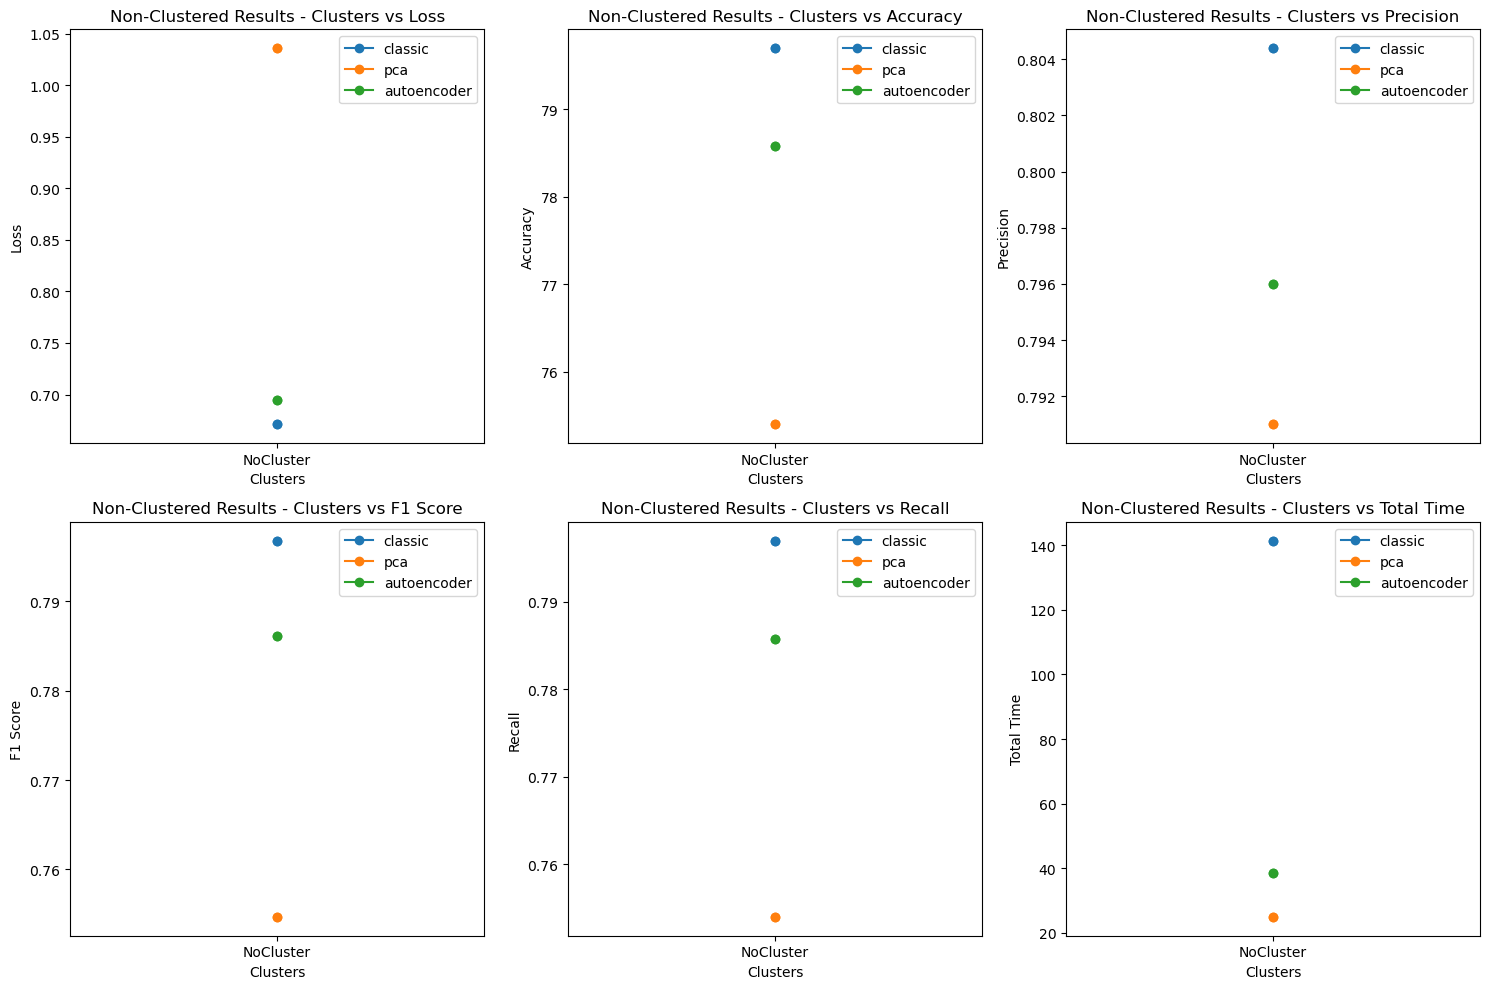


Clustered Results:
classic:
  Final Loss: {2: 0.9650899912834168, 4: 0.7791144682884217, 6: 0.7002888797283172, 8: 0.6341782252311706, 10: 0.6205932253837585}
  Final Accuracy: {2: 76.4, 4: 80.78, 6: 83.14, 8: 85.09, 10: 85.82}
  Final Precision: {2: 0.7928764484878046, 4: 0.8202367082430311, 6: 0.8393103040409434, 8: 0.854993799162264, 10: 0.8620199277359515}
  Final F1 Score: {2: 0.7617446365747026, 4: 0.8073585764897642, 6: 0.8319706260875552, 8: 0.8510890411779866, 10: 0.8581522653048962}
  Final Recall: {2: 0.764, 4: 0.8078000000000001, 6: 0.8314, 8: 0.8509, 10: 0.8582000000000001}
  Total Time: {2: 199.76087760925293, 4: 418.56348967552185, 6: 583.9885773658752, 8: 875.5205240249634, 10: 1123.4134290218353}
pca:
  Final Loss: {2: 0.9212159948348999, 4: 0.8340592746734619, 6: 0.8391960829734803, 8: 0.7794809635162353, 10: 0.7595254321098328}
  Final Accuracy: {2: 73.89, 4: 76.12, 6: 75.07, 8: 76.83, 10: 77.54}
  Final Precision: {2: 0.7762773416371462, 4: 0.7913754809007085, 6: 0

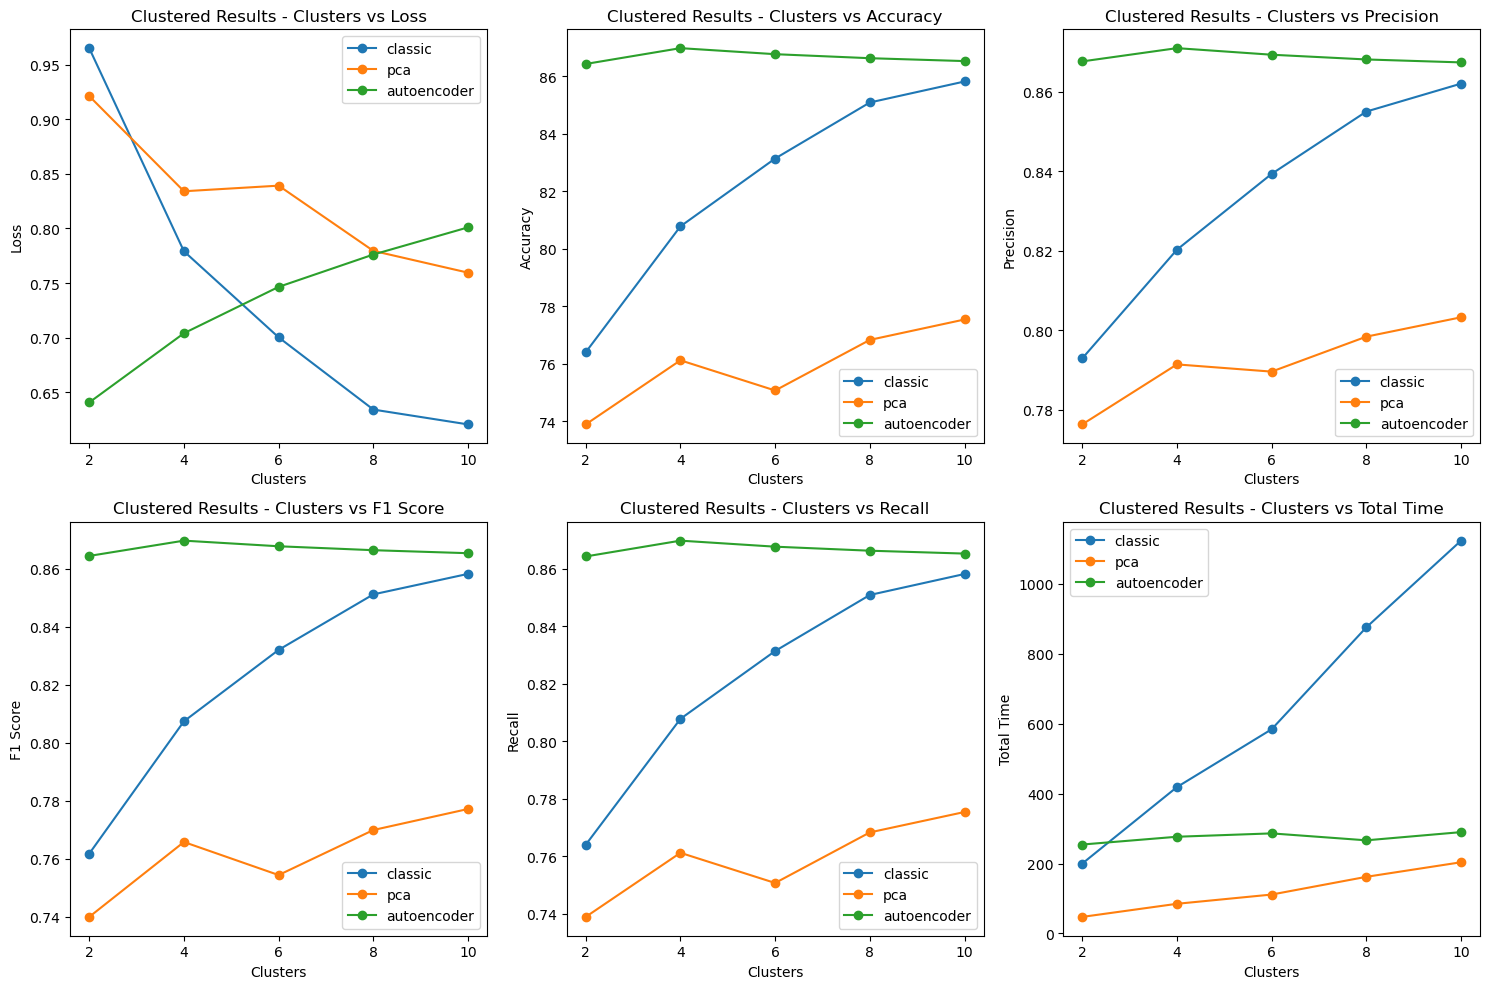

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#TODO: we have to multiply time by 8 first

# Function to compute final metrics
def compute_final_metrics(metrics):
    final_loss = {alpha: data['losses'][-1] for alpha, data in metrics.items()}
    final_accuracy = {alpha: data['accuracy'][-1] for alpha, data in metrics.items()}
    final_precision = {alpha: data['precision'][-1] for alpha, data in metrics.items()}
    final_f1 = {alpha: data['f1'][-1] for alpha, data in metrics.items()}
    final_recall = {alpha: data['recall'][-1] for alpha, data in metrics.items()}

    # Sum of all training times
    total_time = {
        alpha: sum(data.get('TrainingTime', data.get('trainingTime', [0])))
        for alpha, data in metrics.items()
    }

    return final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time

# Function to print results
def print_results(results, title):
    print(f"\n{title}:")
    for method in results.keys():
        final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])
        print(f"{method}:")
        print("  Final Loss:", final_loss)
        print("  Final Accuracy:", final_accuracy)
        print("  Final Precision:", final_precision)
        print("  Final F1 Score:", final_f1)
        print("  Final Recall:", final_recall)
        print("  Total Time:", total_time)

# Function to plot the results
def plot_results(results, title, filename):
    plt.figure(figsize=(15, 10))

    # List of metrics to plot
    metrics_names = ["Loss", "Accuracy", "Precision", "F1 Score", "Recall", "Total Time"]
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 3, i + 1)

        # Plotting each method's metrics
        for method in results.keys():
            final_loss, final_accuracy, final_precision, final_f1, final_recall, total_time = compute_final_metrics(results[method])

            # Select the right metric based on the iteration
            metric_values = {
                "Loss": final_loss,
                "Accuracy": final_accuracy,
                "Precision": final_precision,
                "F1 Score": final_f1,
                "Recall": final_recall,
                "Total Time": total_time
            }[metric]

            # Plot the metric values for each method
            plt.plot(list(metric_values.keys()) + ['NoCluster'], list(metric_values.values()) + [metric_values.get('NoCluster', np.nan)], marker='o', label=method)

        plt.xlabel('Clusters')
        plt.ylabel(metric)
        plt.title(f'{title} - Clusters vs {metric}')
        plt.legend()

    # Adjust layout and save the plot
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Assuming 'results' and 'clusteredResults' are the data for the methods
# Print and plot results for non-clustered and clustered data

print_results(results, "Non-Clustered Results")
plot_results(results, "Non-Clustered Results", "non_clustered_results.png")

print_results(clusteredResults, "Clustered Results")
plot_results(clusteredResults, "Clustered Results", "clustered_results.png")
